In [1]:
import sys
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-9.0'
sys.path.insert(0, 'research/vardl-dev')

import matplotlib.pylab as plt
import matplotlib
import numpy as np
import vardl


import torch
import torch.optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

logger = vardl.utils.setup_logger('vardl', 'work/')

vardl.utils.set_seed(0)


research/vardl-dev/vardl/functional/fwht/__init__.py:28: UserWarning: Including and compiling a custom C++ and CUDA (if available) extension might take a while...
  warnings.warn('Including and compiling a custom C++ and CUDA (if available) extension might take a while...', )
research/vardl-dev/vardl/functional/fwht/__init__.py:31: UserWarning: CXX variable not set. Setting CXX=g++...
  warnings.warn('CXX variable not set. Setting CXX=g++...',)
research/vardl-dev/vardl/functional/fwht/__init__.py:36: UserWarning: PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH
  warnings.warn('PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH')


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


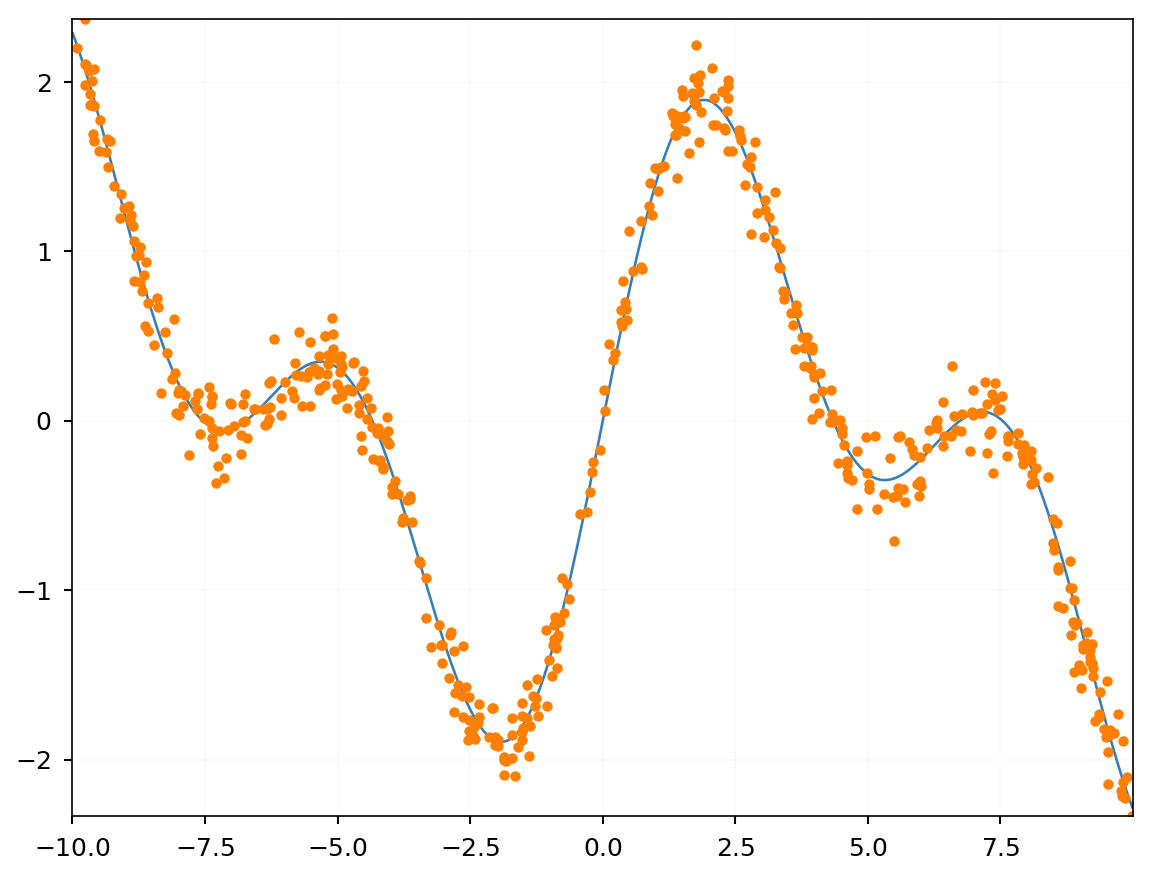

In [2]:
matplotlib.rc_file('~/.config/matplotlib/matplotlibrc')

def f(data):
    return np.sin(data) + np.sin(data/2) + np.sin(data/3) - np.sin(data/4)

xtrain = np.random.uniform(-10, 10, 512)
# xtrain = np.random.choice(xpred, size=128, replace=False)

xpred = np.arange(-10, 10, 0.01)

ytrain = f(xtrain)
ytrain = ytrain + np.exp(-2) * np.random.randn(*ytrain.shape)


fig, ax = plt.subplots(1, 1)

ax.plot(xpred, (f(xpred)),)
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(xtrain, ytrain, 'o', color=color)

plt.show()

In [3]:
vardl.utils.set_seed(0)

train_dataset = TensorDataset(torch.Tensor(xtrain).view(-1, 1), torch.Tensor(ytrain).view(-1, 1))

train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True,
                              drop_last=False,
                              num_workers=0)


In [8]:
vardl.utils.set_seed(0)

# class Cos(nn.Module)
#     def forward(self, input):
#         return input.cos()

class Model(vardl.models.BaseBayesianNet):
    def __init__(self, input_dim, output_dim, likelihood, nmc_train, nmc_test, nlayers, nfeatures, 
                 output_mean=torch.tensor(0.), output_std=torch.tensor(1.)):
        """

        Parameters
        ----------
        input_dim: int
        output_dim: int
        nmc_train: int
        nmc_test: int
        nlayers: int
        nfeatures: int
        activation_function
        """
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nmc_train = nmc_train
        self.nmc_test = nmc_test
        nlayers += 1
        self.nlayers = nlayers
        self.nfearures = nfeatures
        self.output_mean = torch.nn.Parameter(output_mean, requires_grad=False)
        self.output_std = torch.nn.Parameter(output_std, requires_grad=False)
        bias = 1
        

        self.layers = []
        if nlayers == 1:
            self.layers.append(vardl.layers.VariationalLinear(input_dim, output_dim, bias=bias))
        else:
            for i in range(nlayers):
                if i == 0:
                    # First layer
                    layer = vardl.layers.VariationalLinear(input_dim, nfeatures, bias=bias)
                    self.layers.append(layer)
                    self.layers.append(torch.nn.Tanh())

                elif i == nlayers - 1:
                    # Last layer
                    layer = vardl.layers.VariationalLinear(nfeatures, output_dim, bias=bias)
                    self.layers.append(layer)
                else:
                    # Everything else in the middle
                    layer = vardl.layers.VariationalLinear(nfeatures, nfeatures, bias=bias)
                    self.layers.append(layer)
                    self.layers.append(torch.nn.Tanh())

        self.layers = torch.nn.Sequential(*self.layers)
        self.likelihood = vardl.likelihoods.Gaussian() if likelihood == 'gaussian' else vardl.likelihoods.Softmax()

        self.train()

    def train(self, mode=True):
        self.nmc = self.nmc_train if mode else self.nmc_test
        for module in self.children():
            module.train(mode)

    def forward(self, input):
        x = input * torch.ones(self.nmc, 1, 1).to(input.device)
        y = self.layers(x)
        return y * self.output_std + self.output_mean

init_dataloader = DataLoader(train_dataset,
                              batch_size=128,
                              shuffle=True)

## IBLM initialization
model_iblm = Model(1, 1, likelihood='gaussian', nmc_train=1, nmc_test=1024, nlayers=1, nfeatures=50, output_mean=torch.tensor(ytrain.mean()), output_std=torch.tensor(ytrain.std())).cuda()
model_iblm.likelihood.log_noise_var.data.fill_(-1)
initializer = vardl.initializer.IBLMInitializer(model_iblm, init_dataloader, device='cuda', lognoise=model_iblm.likelihood.log_noise_var.data)
initializer.initialize()
model_iblm = model_iblm.cpu()

# Uninformative initializer
model_uninf = Model(1, 1, likelihood='gaussian', nmc_train=1, nmc_test=1024, nlayers=1, nfeatures=50, output_mean=torch.tensor(ytrain.mean()), output_std=torch.tensor(ytrain.std())).cuda()
initializer = vardl.initializer.UninformativeInitializer(model_uninf)
initializer.initialize()
model_uninf = model_uninf.cpu()

[I0821 14:35:42.329 iblm_initializer:69] Initialization with I-BLM
[I0821 14:35:42.331 base_initializer:48] Initialization of layer 2
[I0821 14:35:43.132 base_initializer:48] Initialization of layer 8
[I0821 14:35:43.151 base_initializer:51] Initialization done in 0.820 sec.
[I0821 14:35:43.157 uninformative_initializer:37] Initialization with Uninformative posterior
[I0821 14:35:43.158 base_initializer:48] Initialization of layer 2
[I0821 14:35:43.159 base_initializer:48] Initialization of layer 8
[I0821 14:35:43.161 base_initializer:51] Initialization done in 0.003 sec.


100%|██████████| 1/1 [00:00<00:00, 69.10it/s]


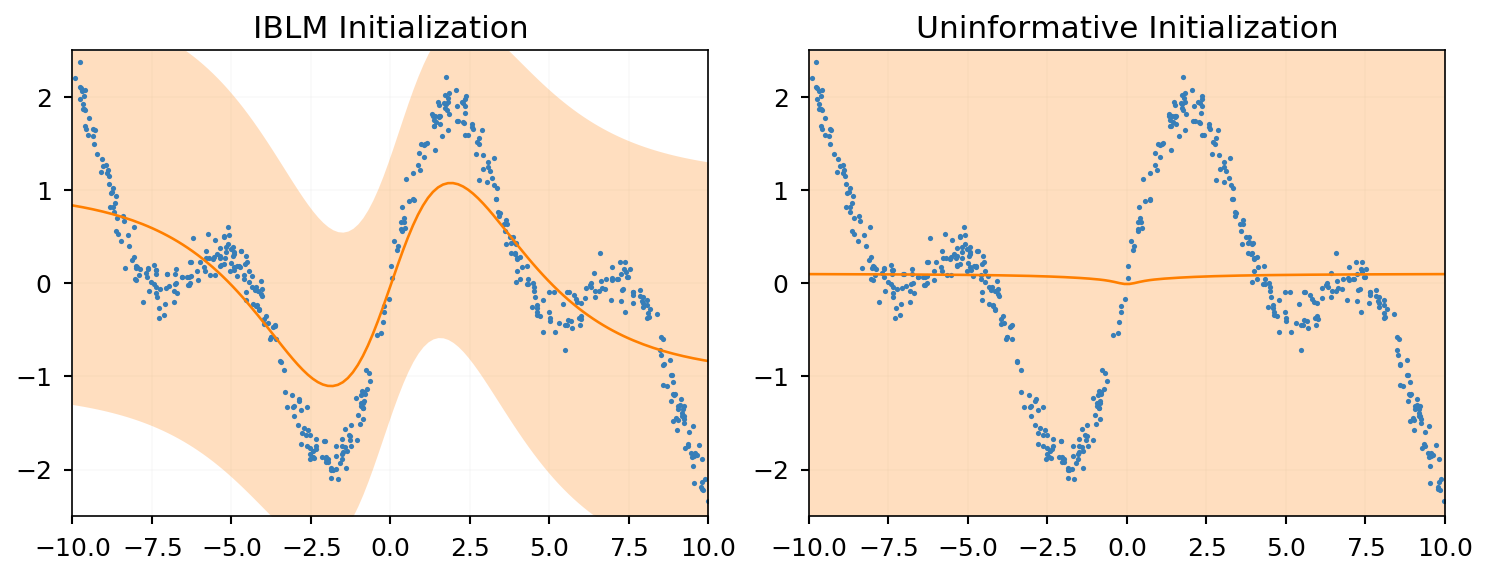

In [9]:
vardl.utils.set_seed(0)
xpred = np.linspace(-10, 10, 128)

with torch.no_grad():
    model_iblm.eval()
    model_uninf.eval()
    # model = model.cpu()
    ypred_iblm = model_iblm(torch.tensor(xpred).float().view(-1, 1))
    ypred_uninf = model_uninf(torch.tensor(xpred).float().view(-1, 1))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 4])
color = '#ff7f00'#next(ax0._get_lines.prop_cycler)['color']
ax0.plot(xtrain, ytrain, '.')
y_m, y_lb, y_ub = model_iblm.likelihood.predict(ypred_iblm, percentile=0.95)
ax0.plot(xpred, y_m, color=color)
ax0.fill_between(xpred, y_lb.reshape(-1), y_ub.reshape(-1), color=color, alpha=0.25, linewidth=0)
ax0.set_ylim(-2.5,2.5)
ax0.set_title('IBLM Initialization')


ax1.plot(xtrain, ytrain, '.')
y_m, y_lb, y_ub = model_uninf.likelihood.predict(ypred_uninf, percentile=0.95)
ax1.plot(xpred, y_m, color=color)
ax1.fill_between(xpred, y_lb.reshape(-1), y_ub.reshape(-1), color=color, alpha=0.25, linewidth=0)
ax1.set_ylim(-2.5,2.5)
ax1.set_title('Uninformative Initialization')
plt.show()
    

In [6]:
!pwd


/mnt/workspace
